Try to use these to fix outputs issue:

https://ipython.readthedocs.io/en/stable/interactive/magics.html
https://notebook.community/lifeinoppo/littlefishlet-scode/RES/REF/python_sourcecode/ipython-master/examples/IPython%20Kernel/Capturing%20Output

# TODO: Add to references for using dgl library

@article{wang2019dgl,
    title={Deep Graph Library: A Graph-Centric, Highly-Performant Package for Graph Neural Networks},
    author={Minjie Wang and Da Zheng and Zihao Ye and Quan Gan and Mufei Li and Xiang Song and Jinjing Zhou and Chao Ma and Lingfan Yu and Yu Gai and Tianjun Xiao and Tong He and George Karypis and Jinyang Li and Zheng Zhang},
    year={2019},
    journal={arXiv preprint arXiv:1909.01315}
}

# TODO: Reference to paper:
https://arxiv.org/abs/1606.09375

conda install -c dglteam/label/th23_cu121 dgl

conda install -c pytorch torchdata

conda install pydantic -c conda-forge

# Load SEED Dataset

### Load RAW EEG

In [1]:
import torch

from dataset_processing.seed_dataset_loader import SeedDatasetLoader

sampling_frequency = 200  # 200 Hz

_loader = SeedDatasetLoader(fs=sampling_frequency)

Going through files:   0%|          | 0/47 [00:00<?, ?it/s]

In [2]:
labels = _loader.get_labels()
labels

array([[ 1,  0, -1, -1,  0,  1, -1,  0,  1,  1,  0, -1,  0,  1, -1]],
      dtype=int16)

In [3]:
channel_order = _loader.get_channel_order()
channel_order

{0: 'FP1',
 1: 'FPZ',
 2: 'FP2',
 3: 'AF3',
 4: 'AF4',
 5: 'F7',
 6: 'F5',
 7: 'F3',
 8: 'F1',
 9: 'FZ',
 10: 'F2',
 11: 'F4',
 12: 'F6',
 13: 'F8',
 14: 'FT7',
 15: 'FC5',
 16: 'FC3',
 17: 'FC1',
 18: 'FCZ',
 19: 'FC2',
 20: 'FC4',
 21: 'FC6',
 22: 'FT8',
 23: 'T7',
 24: 'C5',
 25: 'C3',
 26: 'C1',
 27: 'CZ',
 28: 'C2',
 29: 'C4',
 30: 'C6',
 31: 'T8',
 32: 'TP7',
 33: 'CP5',
 34: 'CP3',
 35: 'CP1',
 36: 'CPZ',
 37: 'CP2',
 38: 'CP4',
 39: 'CP6',
 40: 'TP8',
 41: 'P7',
 42: 'P5',
 43: 'P3',
 44: 'P1',
 45: 'PZ',
 46: 'P2',
 47: 'P4',
 48: 'P6',
 49: 'P8',
 50: 'PO7',
 51: 'PO5',
 52: 'PO3',
 53: 'POZ',
 54: 'PO4',
 55: 'PO6',
 56: 'PO8',
 57: 'CB1',
 58: 'O1',
 59: 'OZ',
 60: 'O2',
 61: 'CB2'}

In [4]:
_eeg_data_df = _loader.get_eeg_data_df()

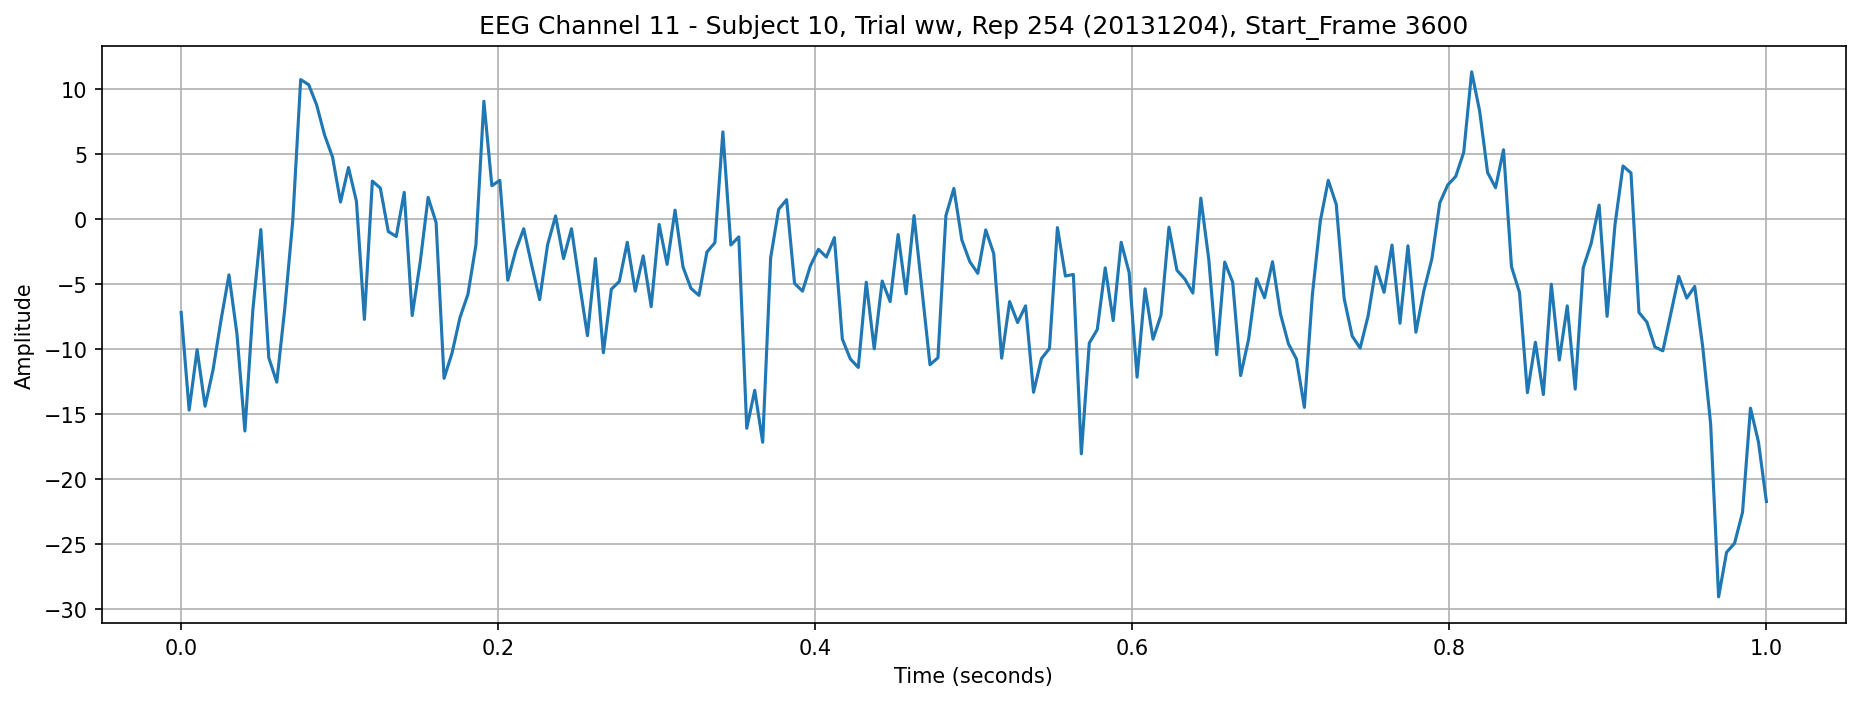

In [5]:
_loader.plot_random_eeg()

In [6]:
del _loader

### Data Augmentation

In [7]:
from dataset_processing.eeg_augmentation import EEGAugmentation

_augmentor = EEGAugmentation(_eeg_data_df)
_augmented_df = _augmentor.augment_data()
del _augmentor, _eeg_data_df

Going through eeg_data_df rows: 0it [00:00, ?it/s]

# Pre-Training

In [8]:
from torch.utils.data import DataLoader
from dataset_processing.eeg_dataset import EEGDataset
from model.pre_training.do_pre_training import PreTraining

# From the paper
pretraining_batch_size = 256

In [9]:
# TODO: Add in bachelor thesis how `num_workers` was chosen with code from w_testing_values notebook

# Custom cleanup function, useful when using the dataloader too much,
# as it's bugged and needs manual cleaning (because of Jupyter Notebook)
def cleanup_data_loader(loader):
    # noinspection PyProtectedMember
    if loader._iterator is not None:
        # noinspection PyProtectedMember
        loader._iterator._shutdown_workers()

### Dataset Loader

In [10]:
try:
    # noinspection PyUnresolvedReferences,PyUnboundLocalVariable
    _dataset
except NameError:
    # noinspection PyUnboundLocalVariable
    _dataset = EEGDataset(_augmented_df)
    del _augmented_df

In [11]:
num_workers = 5

data_loader = DataLoader(
    _dataset,
    batch_size=pretraining_batch_size,
    shuffle=True,
    pin_memory=True,
    persistent_workers=True,

    num_workers=num_workers,
    prefetch_factor=2,  # Default: 2 for `num_workers` > 0  # TODO: Maybe set to 3-4
)
# del _augmented_df, _dataset

### Do the pre-training

In [12]:
import gc
print(f"Garbage collector: collected {gc.collect()} objects.")

Garbage collector: collected 42 objects.


In [13]:
# from importlib import reload
# import model.pre_training.do_pre_training
# 
# reload(model.pre_training.do_pre_training)
# 
# PreTraining = model.pre_training.do_pre_training.PreTraining

In [14]:
# TODO: Use for simplified training: https://pytorch-ignite.ai/tutorials/beginner/01-getting-started/

In [15]:
print(f"Starting pre-training with {num_workers} workers loading the dataset")

pretraining_model_trainer = PreTraining(
    data_loader=data_loader,
    sampling_frequency=sampling_frequency,
    pretraining_model_save_dir="model_params/pretraining",
    scheduler_patience=50,
    early_stopping_patience=100,
    epochs=2000,
)
pretraining_model_trainer.train()

cleanup_data_loader(data_loader)

Starting pre-training with 5 workers loading the dataset


Exception: Model folder not empty, probably already trained: model_params/pretraining

In [16]:
pretraining_model = PreTraining(
    data_loader=None,
    sampling_frequency=sampling_frequency,
    pretraining_model_save_dir="model_params/pretraining",
    scheduler_patience=50,
    early_stopping_patience=100,
    epochs=2000,
    to_train=False,
)
pretraining_model.load_model(2000)

Trying to load model from model_params/pretraining_saved/pretrained_model__epoch_2000.pt
Loaded model from model_params/pretraining_saved/pretrained_model__epoch_2000.pt


In [17]:
for data in data_loader:
    xT, xT_augmented, xF, xF_augmented = pretraining_model._move_to_device(*data)
    break
channel_count = xT.size(1)
xT.size(), xF.size()

(torch.Size([256, 62, 200]), torch.Size([256, 62, 200]))

In [18]:
from model.fine_tuning.gcn import GCN

zT = torch.cat([
    pretraining_model.PT(pretraining_model.ET(xT[:, i, :].unsqueeze(1)))
    for i in range(channel_count)
], dim=1)

zF = torch.cat([
    pretraining_model.PF(pretraining_model.EF(xF[:, i, :].unsqueeze(1)))
    for i in range(channel_count)
], dim=1)

Z = torch.cat([zT, zF], dim=-1)

adj_matrix = GCN.build_adjacency_matrix(Z)

Z.size(), adj_matrix.size()

(torch.Size([256, 62, 256]), torch.Size([256, 62, 62]))

In [56]:
import torch
from model.fine_tuning.dense_cheb_conv import DenseChebConv

feat = torch.ones(6, 10)
adj = torch.tensor([[0., 0., 1., 0., 0., 0.],
                        [1., 0., 0., 0., 0., 0.],
                        [0., 1., 0., 0., 0., 0.],
                        [0., 0., 1., 0., 0., 1.],
                        [0., 0., 0., 1., 0., 0.],
                        [0., 0., 0., 0., 0., 0.]])
conv = DenseChebConv(10, 2, 2)
res = conv(adj, feat)
res

tensor([[-0.8028, -1.7049],
        [-0.8028, -1.7049],
        [-0.8028, -1.7049],
        [-2.6551, -1.1607],
        [ 0.5070, -2.0897],
        [ 3.6690, -3.0187]], grad_fn=<AddBackward0>)

In [27]:
Z.size(), adj_matrix.size()

(torch.Size([256, 62, 256]), torch.Size([256, 62, 62]))

In [30]:
gcn = DenseChebConv(128 * 2, 64, 3).to(Z.device)
gcn(adj_matrix[0, :, :], Z[0, :, :]).size()

cuda:0 cuda:0 cuda:0


torch.Size([62, 64])

In [ ]:
from importlib import reload
import model.fine_tuning.gcn

reload(model.fine_tuning.gcn)
GCN = model.fine_tuning.gcn.GCN

gcn = GCN(
    input_dim=128 * 2,
    hidden_dims=[128, 64],
    k_order=3
).to(pretraining_model.device)

gcn(Z, ???, adj_matrix)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs

# Fine-Tuning

### Dataset Loader

In [ ]:
# from torch.utils.data import DataLoader
# from dataset_processing.eeg_dataset import EEGDataset
# 
# # From the paper
# pretraining_batch_size = 256
# 
# _dataset = EEGDataset(_augmented_df)
# data_loader = DataLoader(_dataset, batch_size=pretraining_batch_size, shuffle=True)
# del _augmented_df, _dataset

### Do the fine-tuning

In [ ]:
# from model.fine_tuning.do_fine_tuning import FineTuning
# 
# finetuning = FineTuning(
#     data_loader=data_loader,
#     sampling_frequency=sampling_frequency,
#     finetuning_model_save_dir="model_params/finetuning",
#     epochs=10,
# )
# finetuning.train()

# Ideas

Do a correlation matrix between the channels of the EEG signals.
Then when doing the joint whatever model, use the "distances" between the channels (like the hamming distance but not really), as a "weight" for training the joining etc.

Or maybe just output something that could show each channel's contribution towards the final emotion prediction.